In [1]:
from datetime import datetime
import json
import os
import warnings

from matplotlib import pyplot as plt
import pandas as pd


warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def get_setup(experiment):
    return '_'.join(experiment.split('_')[2:])

In [3]:
experiment_names = [e.removesuffix('_conf.json') for e in os.listdir('experiments') if e.endswith('_conf.json')]
experiment_configs = []
experiment_results = []

for experiment in experiment_names:
    try:
        with open(f'experiments/{experiment}_conf.json', 'r') as f:
            conf = json.load(f)
            conf['experiment'] = experiment
            conf['setup'] = get_setup(experiment)
            experiment_configs.append(conf)
        
        experiment_result_files = os.listdir(f'experiments/results/{experiment}')
        
        for result_file in experiment_result_files:
            result_date = datetime.strptime(result_file.split('_')[-1].split('.json')[0], '%Y%m%d%H%M%S')
            result = pd.read_json(f'experiments/results/{experiment}/{result_file}',lines=True)
            result['experiment'] = experiment
            result['modification_date'] = result_date
            experiment_results.append(result)
    except:
        print(f'Error reading experiment {experiment}')

experiment_configs = pd.DataFrame(experiment_configs)
experiment_results = pd.concat(experiment_results)
experiment_results['num_1qub_gates'] = experiment_results['gate_sizes'].apply(lambda d: d['1'])
experiment_results['num_2qub_gates'] = experiment_results['gate_sizes'].apply(lambda d: d['2'])

In [4]:
experiment_results_agg = (
    experiment_results
        .groupby('experiment')
        .agg({
            'rep': 'count',
            'steps': ['mean', 'median', 'std', 'max', 'min'],
            'num_gates': ['mean', 'median', 'std', 'max', 'min'],
            'num_2qub_gates': ['mean', 'median', 'std', 'max', 'min'],
            'cost': ['mean', 'median', 'std'], 
            'fidelity': ['mean', 'median', 'std', 'max', 'min']
        })
    )

experiment_results_agg.columns = ['_'.join(map(str, col)) for col in experiment_results_agg.columns.to_flat_index()]

experiment_results_agg['infidelity_mean'] = 1 - experiment_results_agg['fidelity_mean']
experiment_results_agg['infidelity_median'] = 1 - experiment_results_agg['fidelity_median']
experiment_results_agg['infidelity_min'] = 1 - experiment_results_agg['fidelity_max']
experiment_results_agg['infidelity_max'] = 1 - experiment_results_agg['fidelity_min']

In [5]:
experiments_df = pd.merge(experiment_configs, experiment_results_agg, how='inner', on='experiment')

if (experiments_df['num_gates_std'] != 0).any():
    print('Warning: There are experiments with inconsistent number of gates')

# N = 15

* Required qubits: $n_x = 1,\ n_y = 2$
* Factorization: $15 = 3 \times 5$
* Factor simplification: $3 \rightarrow 1,\ 5 \rightarrow 2$
* Binary factors: $1 \rightarrow 1,\ 2 \rightarrow 10$
* Solution: $\ket{101}$

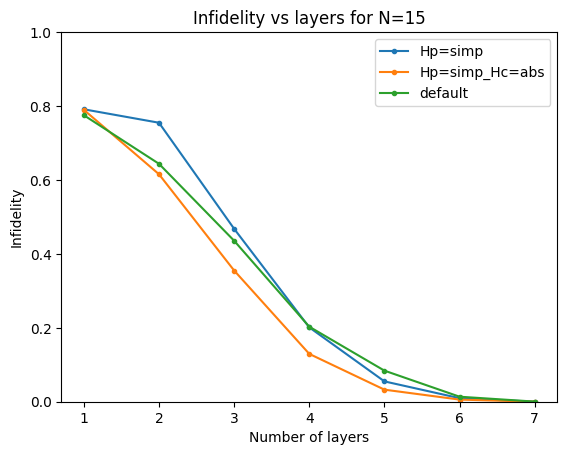

In [6]:
N = 15

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers'])

setups = df['setup'].unique()
layers = df['layers'].unique()

for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('layers', 'infidelity_median', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Infidelity vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

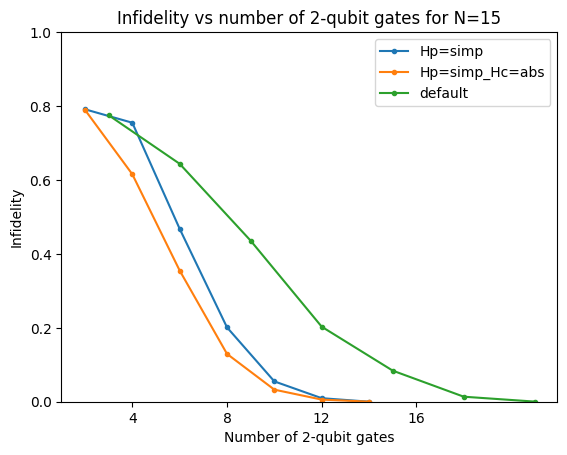

In [7]:
for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('num_2qub_gates_max', 'infidelity_median', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Infidelity vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.xticks([4,8,12,16])
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

# N = 21

* Required qubits: $n_x = 1,\ n_y = 2$
* Factorization: $21 = 3 \times 7$
* Factor simplification: $3 \rightarrow 1,\ 7 \rightarrow 3$
* Binary factors: $1 \rightarrow 1,\ 3 \rightarrow 11$
* Solution: $\ket{111}$

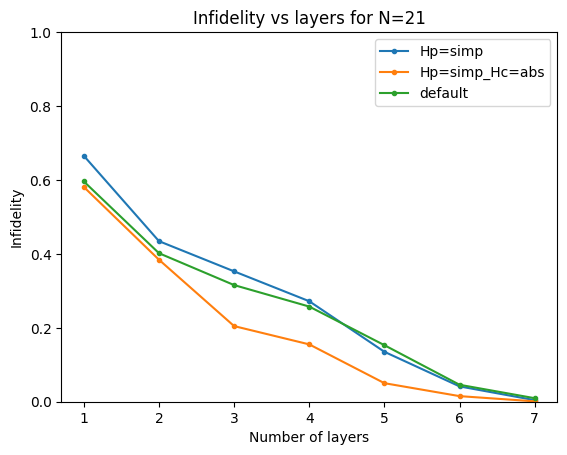

In [8]:
N = 21

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers'])

setups = df['setup'].unique()
layers = df['layers'].unique()

for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('layers', 'infidelity_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Infidelity vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

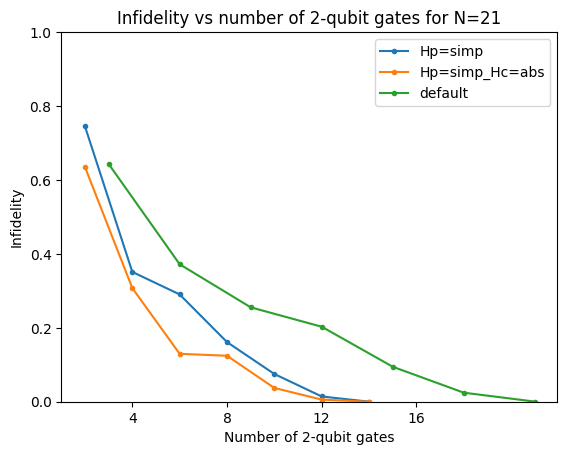

In [9]:
for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('num_2qub_gates_max', 'infidelity_median', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Infidelity vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.xticks([4,8,12,16])
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

# N = 33

* Required qubits: $n_x = 2,\ n_y = 3$
* Factorization: $33 = 3 \times 11$
* Factor simplification: $3 \rightarrow 1,\ 11 \rightarrow 5$
* Binary factors: $1 \rightarrow 1,\ 5 \rightarrow 101$
* Solution: $\ket{01101}$

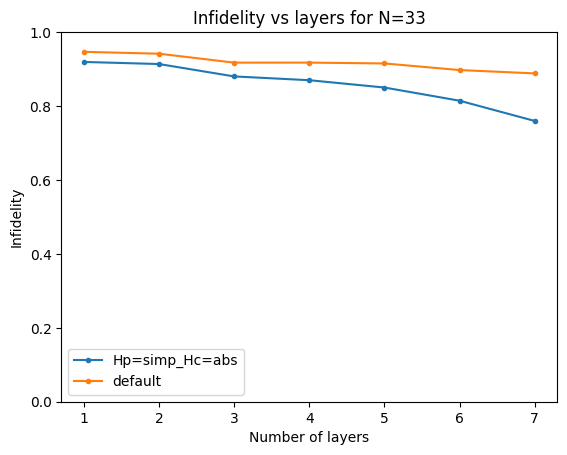

In [10]:
N = 33

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers'])

setups = df['setup'].unique()
layers = df['layers'].unique()

for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('layers', 'infidelity_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Infidelity vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

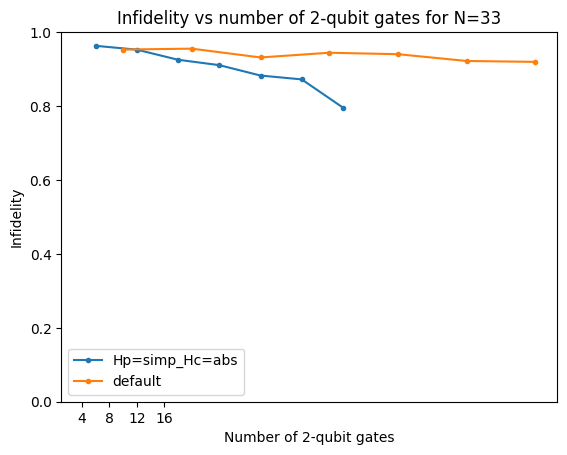

In [11]:
for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('num_2qub_gates_max', 'infidelity_median', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Infidelity vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.xticks([4,8,12,16])
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

# N = 35

* Required qubits: $n_x = 2,\ n_y = 3$
* Factorization: $35 = 5 \times 7$
* Factor simplification: $5 \rightarrow 2,\ 7 \rightarrow 3$
* Binary factors: $2 \rightarrow 10,\ 3 \rightarrow 11$
* Solutions: $\ket{01110}$ and $\ket{11010}$

Degeneracy: solutions 10 and 11 can be exchanged and fit in both $n_x$ and $n_y$ qubits

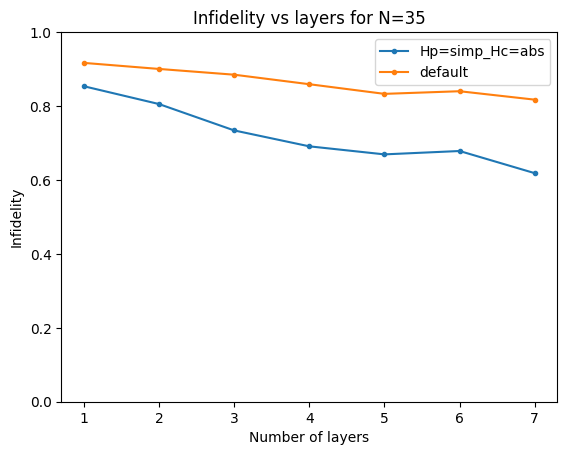

In [12]:
N = 35

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers'])

setups = df['setup'].unique()
layers = df['layers'].unique()

for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('layers', 'infidelity_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Infidelity vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

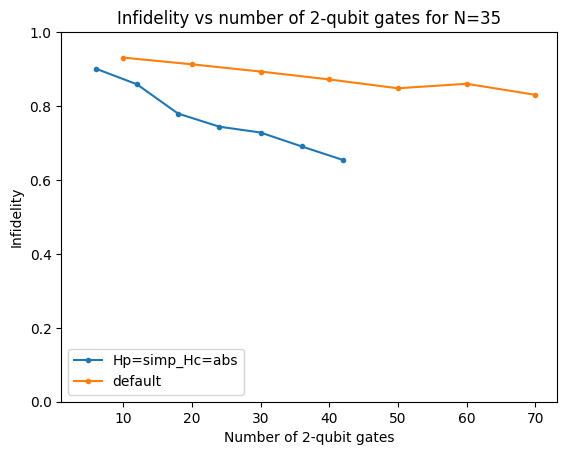

In [13]:
for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('num_2qub_gates_max', 'infidelity_median', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Infidelity vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.xticks([10,20,30,40,50, 60, 70])
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

# N = 39

* Required qubits: $n_x = 2,\ n_y = 3$
* Factorization: $35 = 5 \times 7$
* Factor simplification: $5 \rightarrow 2,\ 7 \rightarrow 3$
* Binary factors: $2 \rightarrow 10,\ 3 \rightarrow 11$
* Solutions: $\ket{01110}$ and $\ket{11010}$

Degeneracy: solutions 10 and 11 can be exchanged and fit in both $n_x$ and $n_y$ qubits

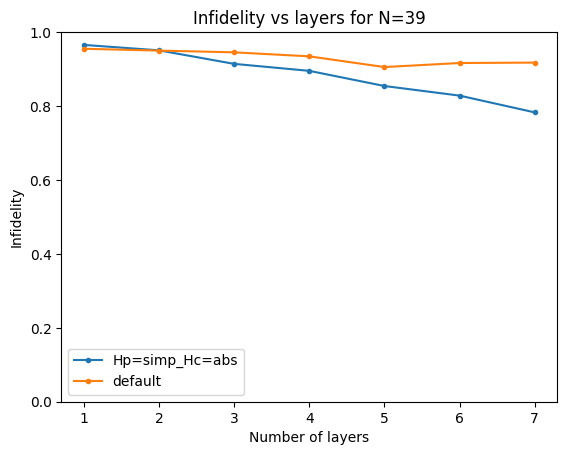

In [14]:
N = 39

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers'])

setups = df['setup'].unique()
layers = df['layers'].unique()

for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('layers', 'infidelity_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Infidelity vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

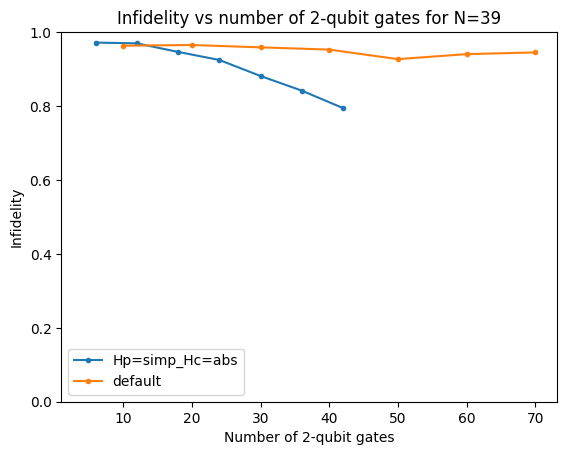

In [15]:
for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('num_2qub_gates_max', 'infidelity_median', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Infidelity vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.xticks([10,20,30,40,50, 60, 70])
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);